**Gestione Energetica ed Automazione negli Edifici (GEAE) A.A. 2024/2025**

*Tutto il materiale didattico messo a disposizione degli studenti (compresi script, markdown, presentazioni, video e Virtual Classroom) è da utilizzarsi esclusivamente per scopi didattici e nell’ambito del corso di “gestione energetica e automazione negli edifici”. È vietata ogni forma di utilizzo diverso, redistribuzione e pubblicazione on line. Per ogni eventuale dubbio o richiesta contattare il titolare del corso prof. Alfonso Capozzoli a alfonso.capozzoli@polito.it*

# Internal Energy Benchmarking

## Introduction and pre-processing

### Importing necessary libraries



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For linear regression and metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from math import sqrt

In [2]:
df = pd.read_csv('../data/pre_retrofit.csv')

In [3]:
df['DATA_misura'] = pd.to_datetime(df['DATA_misura'], format="%Y-%m-%d")
df['DATA_inizio'] = pd.to_datetime(df['DATA_inizio'], format="%Y-%m-%d")

### Extract days and hours of operations of the system

In [4]:
# Calculate the number of days between measurement dates
df['giorni_letture'] = (df['DATA_misura'] - df['DATA_inizio']).dt.days

# Calculate total hours in the metering period
df['ore_tot'] = df['giorni_letture'] * 24

# Calculate the hours when the heat generator is ON
df['ore_ON'] = df['ore_tot'] - df['giorni_off'] * 24

### Calculate the average thermal power of the system

In [5]:
# Define the conversion factor
cf = 10.94

# Calculate the average thermal power
df['potenza'] = (df['consumo_gasm_smc'] * cf) / df['ore_ON']

# Replace infinite or NaN values with 0
df['potenza'] = df['potenza'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['potenza'])

# Filter out records where 'tipo_misura' is 'OFF'
df1 = df[df['tipo_misura'] != 'OFF']

## Fitting linear regression model for each season

### Define a function to fit a linear model within a loop

In [6]:
def fit_linear_model(data, season):
    """
    Fits a linear model of 'potenza' vs 'T_media' for a given season using scikit-learn.
    """
    # Filter data for the specific season
    season_data = data[data['Stagione'] == season]

    # Define independent and dependent variables
    X = season_data[['T_media']].values # 2D array for scikit-learn
    y = season_data['potenza'].values # 1D array

    # Fit the linear regression model
    model = LinearRegression().fit(X, y)

    return model

1. **`season_data = data[data['Stagione'] == season]`**
   - This line filters the input DataFrame (`data`) to create a new DataFrame (`season_data`) containing only the rows where the value in the `'Stagione'` column matches the given `season`.
   - This allows us to focus the analysis on a specific season (e.g., winter, summer).

2. **`X = season_data[['T_media']].values.reshape(-1, 1)`**
   - This line defines the independent variable (`X`) for the linear regression model.
   - **`season_data[['T_media']]`** selects the column `'T_media'` from `season_data`, which represents the average temperature.

3. **`y = season_data['potenza'].values`**
   - This line defines the dependent variable (`y`) for the linear regression model.
   - **`season_data['potenza']`** selects the column `'potenza'` from `season_data`, representing the power values.
   - **`.values`** converts the selected column into a NumPy array.

4. **`model = LinearRegression().fit(X, y)`**
   - This line creates an instance of the `LinearRegression` model from scikit-learn and fits it to the independent (`X`) and dependent (`y`) variables.
   - **`LinearRegression().fit(X, y)`** estimates the coefficients of the linear model that best fits the data provided.


In [7]:
# List of seasons
seasons = ['2012-2013', '2013-2014', '2014-2015', '2015-2016']

### Call the function to fit the model for each season in a loop

In [8]:
# Dictionary to store models
models = {}

# Fit models for each season
for season in seasons:
    models[season] = fit_linear_model(df1, season)
    X = df1[df1['Stagione'] == season][['T_media']].values
    y = df1[df1['Stagione'] == season]['potenza'].values
    r2 = models[season].score(X, y)
    intercept = models[season].intercept_
    coef = models[season].coef_[0]
    print(f"Summary for season {season}: R² = {r2:.2f} / Intercept = {intercept:.2f} / Coefficient = {coef:.2f}")

Summary for season 2012-2013: R² = 0.98 / Intercept = 76.42 / Coefficient = -4.35
Summary for season 2013-2014: R² = 0.97 / Intercept = 76.89 / Coefficient = -4.46
Summary for season 2014-2015: R² = 0.98 / Intercept = 75.55 / Coefficient = -4.68
Summary for season 2015-2016: R² = 0.98 / Intercept = 69.58 / Coefficient = -3.90


### Define a function to plot the regression line and data points for each season

In [9]:
def plot_regression(data, model, season):
    """
    Plots the regression line and data points for a given season.
    """
    # Filter data for the season
    season_data = data[data['Stagione'] == season]

    # Create scatter plot of the data points
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='T_media', y='potenza', hue='tipo_misura', data=season_data, s=50)

    # calculate T_max when y = 0
    max_t_plot = -model.intercept_ / model.coef_[0]
    # calculate P_max when T = -8
    max_p_plot = model.predict([[-8.0]])[0]
    # Generate values for plotting the regression line
    X_plot = np.linspace(-8.0, max_t_plot, 100).reshape(-1, 1)
    y_plot = model.predict(X_plot)

    # Plot the regression line
    plt.plot(X_plot, y_plot, color='blue', linestyle='--', linewidth=2)
    # add vertical line at T = -8
    plt.axvline(x=-8, color='red', linestyle='--', linewidth=1)

    # Set plot limits
    plt.xlim(-10, 20)
    plt.ylim(0, max_p_plot)

    # Set labels and title
    plt.xlabel('Average External Temperature [°C]')
    plt.ylabel('Power [kW]')
    plt.title(f"Season {season}")

    plt.legend()
    plt.show()

1. **`season_data = data[data['Stagione'] == season]`**
   - This line filters the input DataFrame (`data`) to create a new DataFrame (`season_data`) containing only the rows where the value in the `'Stagione'` column matches the given `season`.
   - This helps us focus the visualization on data relevant to the specified season.

2. **`plt.figure(figsize=(8, 6))`**
   - This line initializes a new figure for plotting, with a specified size of 8 by 6 inches.
   - It ensures that the plot has a consistent and appropriate size for visualization.

3. **`sns.scatterplot(x='T_media', y='potenza', hue='tipo_misura', data=season_data, s=50)`**
   - This line creates a scatter plot of the filtered data (`season_data`).
   - **`x='T_media'`** and **`y='potenza'`** specify the x-axis and y-axis variables, representing average temperature and power, respectively.
   - **`hue='tipo_misura'`** adds a color dimension to distinguish between different measurement types.
   - **`s=50`** sets the marker size for the scatter plot points.

4. **`X_plot = np.linspace(season_data['T_media'].min(), season_data['T_media'].max(), 100).reshape(-1, 1)`**
   - This line generates 100 equally spaced values between the minimum and maximum of `'T_media'` in the season data.
   - **`.reshape(-1, 1)`** reshapes the generated values into a two-dimensional array suitable for prediction.

5. **`y_plot = model.predict(X_plot)`**
   - This line uses the linear regression model (`model`) to predict power values (`y_plot`) for the generated temperature values (`X_plot`).
   - It allows us to plot the regression line that fits the data.

6. **`plt.plot(X_plot, y_plot, color='blue', linestyle='--', linewidth=2)`**
   - This line plots the regression line on the figure.
   - **`color='blue'`** sets the line color, **`linestyle='--'`** creates a dashed line, and **`linewidth=2`** controls the line thickness.

7. **`plt.xlim(0, 20)` and `plt.ylim(0, 70)`**
   - These lines set the limits for the x-axis (temperature) and y-axis (power).
   - This helps keep the plot focused on a meaningful range for analysis.

8. **`plt.xlabel('Average External Temperature [°C]')` and `plt.ylabel('Power [kW]')`**
   - These lines set the labels for the x and y axes to provide context for the data being plotted.

9. **`plt.title(f"Season {season}")`**
   - This line sets the title for the plot.
   - It dynamically includes the season name to clarify which data is being visualized.

10. **`plt.legend()`**
    - This line adds a legend to the plot.
    - It provides information about the different measurement types indicated by the hue parameter in the scatter plot.

11. **`plt.show()`**
    - This line displays the plot.


### Call the function to plot the regression line for each season

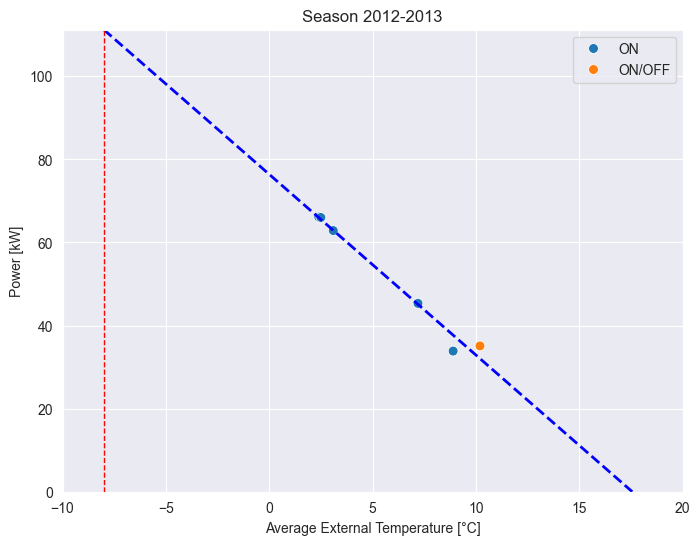

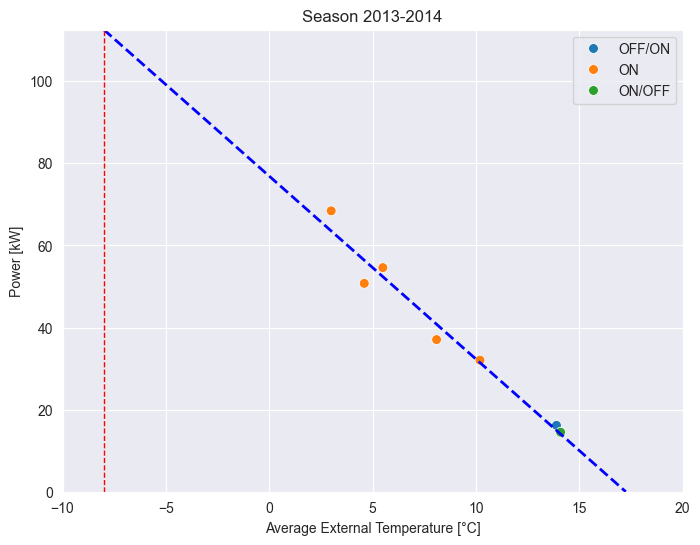

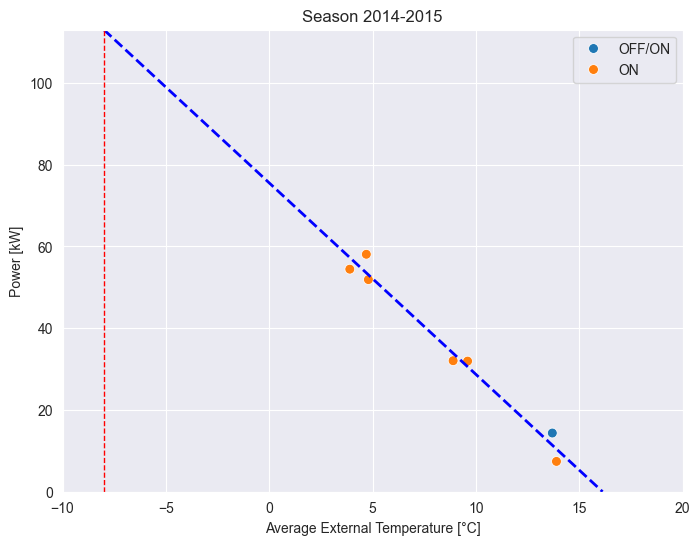

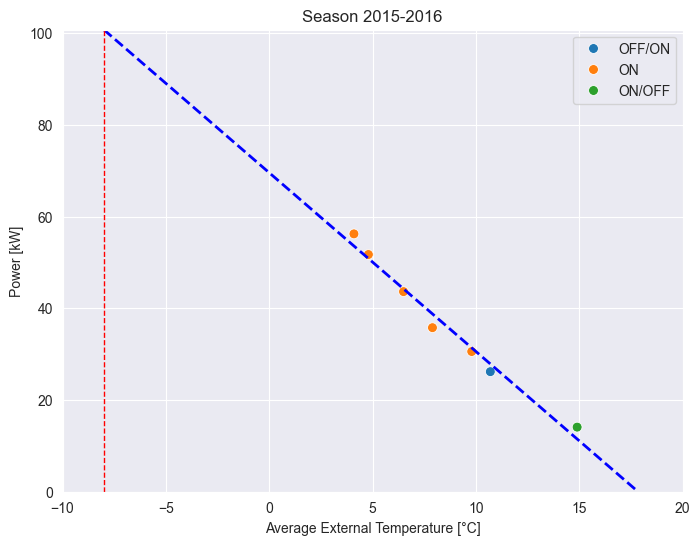

In [10]:
for season in seasons:
    plot_regression(df1, models[season], season)

## Overall model

### Define the dataframe

In [11]:
df_tot = df[df['tipo_misura'] != 'OFF']

### Define the independent and dependent variables

In [12]:
X_tot = df_tot[['T_media']].values
y_tot = df_tot['potenza'].values

### Fit the model

In [13]:
lm_tot = LinearRegression().fit(X_tot, y_tot)

### Calculate the R² of the overall model

In [14]:
r2_tot = lm_tot.score(X_tot, y_tot)
print(f"Summary of the overall model: R² = {r2_tot:.2f}")

Summary of the overall model: R² = 0.97


### Plot the overall regression

Create a scatter plot of the data points and the regression line for the overall model
Color the data points based on the season.

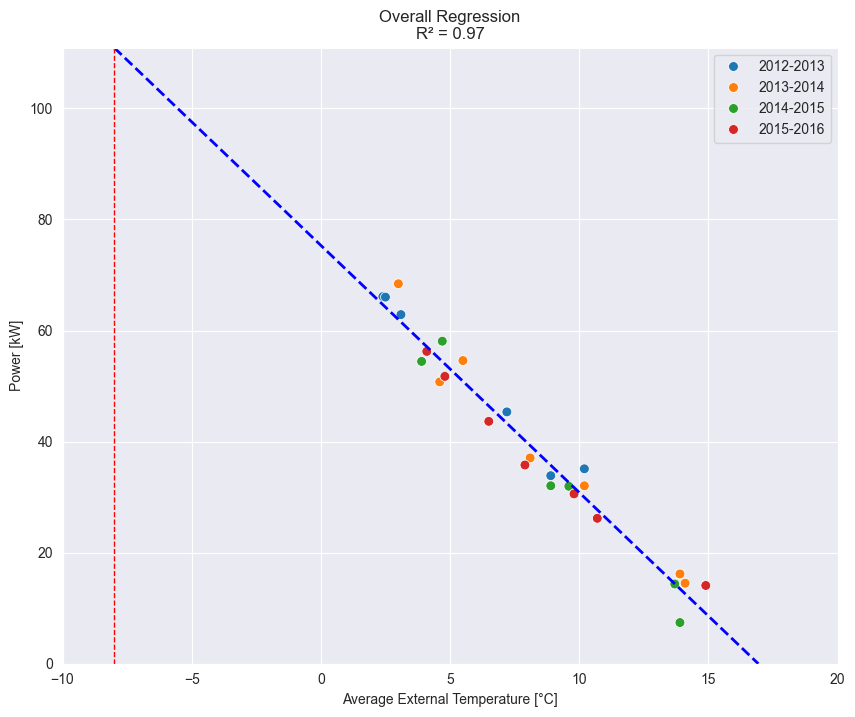

In [15]:
# Plot the overall regression
plt.figure(figsize=(10, 8))
sns.scatterplot(x='T_media', y='potenza', hue='Stagione', data=df_tot, s=50)

# calculate T_max when y = 0
max_t_plot = -lm_tot.intercept_ / lm_tot.coef_[0]
# calculate P_max when T = -8
max_p_plot = lm_tot.predict([[-8.0]])[0]
# Generate values for plotting the regression line
X_plot = np.linspace(-8.0, max_t_plot, 100).reshape(-1, 1)
y_plot = lm_tot.predict(X_plot)
plt.plot(X_plot, y_plot, color='blue', linestyle='--', linewidth=2)
# add vertical line at T = -8
plt.axvline(x=-8, color='red', linestyle='--', linewidth=1)

# Set plot limits
plt.xlim(-10, 20)
plt.ylim(0, max_p_plot)

# Set labels and title
plt.xlabel('Average External Temperature [°C]')
plt.ylabel('Power [kW]')
plt.title(f"Overall Regression\nR² = {r2_tot:.2f}")

plt.legend()
plt.show()

### Assign the predicted values to a new column of the pre-retrofit dataframe

In [16]:
df_tot['pred'] = lm_tot.predict(df_tot[['T_media']].values)

## Model evaluation

### QQ plot

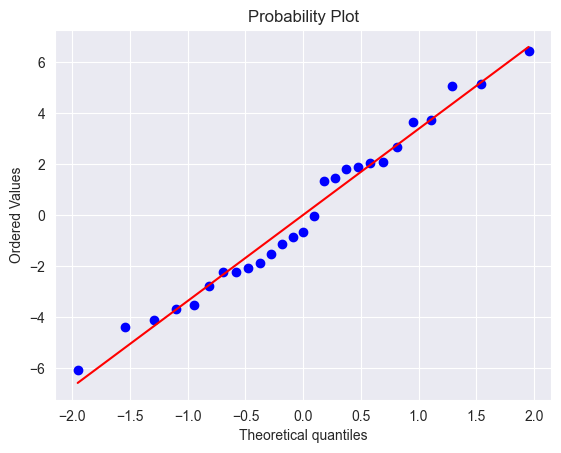

In [17]:
import scipy.stats as stats

residuals = df_tot['potenza'] - df_tot['pred']
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

1. **`stats.probplot(residuals, dist="norm", plot=plt)`**
   - This line generates a Q-Q plot to visually assess whether the residuals follow a normal distribution.
   - **`stats.probplot()`** is a function from the `scipy.stats` library used to create probability plots.
   - **`residuals`** represents the residual values from a regression model.
   - **`dist="norm"`** specifies that the distribution to compare against is the normal distribution.
   - **`plot=plt`** tells the function to use `matplotlib` (`plt`) for plotting the Q-Q plot, providing a visual comparison of the residuals to a normal distribution.


### Plot histogram of residuals

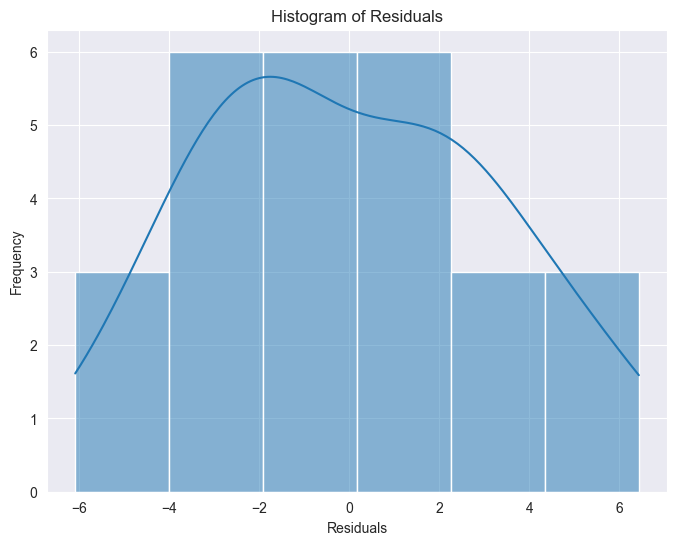

In [18]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Calculate MAPE, RMSE, and CVRMSE

In [19]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(df_tot['potenza'], df_tot['pred']) * 100
print(f"MAPE: {mape:.2f}%")

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(df_tot['potenza'], df_tot['pred']))
print(f"RMSE: {rmse:.2f}")

# Calculate Coefficient of Variation of RMSE (CVRMSE)
cvrmse = (rmse / df_tot['potenza'].mean()) * 100
print(f"CVRMSE: {cvrmse:.2f}%")


MAPE: 10.41%
RMSE: 3.20
CVRMSE: 7.93%


## Saving calculations on post-retrofit data

### import the post-retrofit data

In [20]:
df_post = pd.read_csv('../data/post_retrofit.csv')

df_post['DATA_misura'] = pd.to_datetime(df_post['DATA_misura'], format="%d/%m/%Y")
df_post['DATA_inizio'] = pd.to_datetime(df_post['DATA_inizio'], format="%d/%m/%Y")

df_post['giorni_letture'] = (df_post['DATA_misura'] - df_post['DATA_inizio']).dt.days
df_post['ore_tot'] = df_post['giorni_letture'] * 24
df_post['ore_ON'] = df_post['ore_tot'] - df_post['giorni_off'] * 24
df_post['potenza'] = (df_post['consumo_gasm_smc'] * cf) / df_post['ore_ON']
df_post['potenza'] = df_post['potenza'].replace([np.inf, -np.inf], np.nan)
df_post = df_post.dropna(subset=['potenza'])
df_post_clean = df_post[df_post['tipo_misura'] != 'OFF']

### Plot model and post-retrofit data

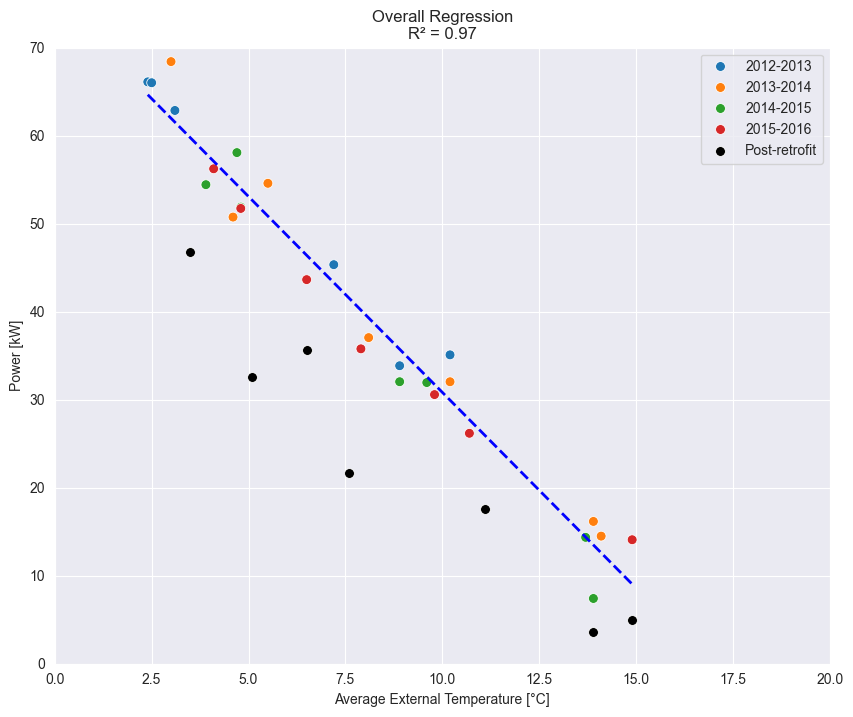

In [21]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='T_media', y='potenza', hue='Stagione', data=df_tot, s=50)
sns.scatterplot(x='T_media', y='potenza', color='black', data=df_post_clean, s=50, label="Post-retrofit")

X_plot = np.linspace(df_tot['T_media'].min(), df_tot['T_media'].max(), 100).reshape(-1, 1)
y_plot = lm_tot.predict(X_plot)
plt.plot(X_plot, y_plot, color='blue', linestyle='--', linewidth=2)
    
plt.xlim(0, 20)
plt.ylim(0, 70)

plt.xlabel('Average External Temperature [°C]')
plt.ylabel('Power [kW]')
plt.title(f"Overall Regression\nR² = {r2_tot:.2f}")

plt.legend()
plt.show()

### Assign the predicted values to a new column of the post-retrofit dataframe

In [22]:
df_post_clean['pred'] = lm_tot.predict(df_post_clean[['T_media']].values)

## Energy saving assessment

### Calculate the estimated consumption in post retrofit

In [23]:
df_post_clean['consumo_stimato_smc'] = df_post_clean['pred'] * df_post_clean['ore_ON'] / cf

### Calculate the energy saving

In [24]:
energy_saving = df_post_clean['consumo_stimato_smc'].sum() - df_post_clean['consumo_gasm_smc'].sum()
print(f"Energy saving: {energy_saving:.2f} smc")

Energy saving: 4959.75 smc


In [25]:
energy_saving_percentage = (energy_saving / df_post_clean['consumo_stimato_smc'].sum()) * 100
print(f"Energy saving percentage: {energy_saving_percentage:.2f}%")

Energy saving percentage: 33.47%


### Uncertainty analysis

In [26]:
p = 1
n = len(X_tot)
# calculate standard error
se = np.sqrt(np.sum(residuals**2) / (n - p - 1))

# calculate confidence interval
alpha = 0.05
t_value = stats.t.ppf(1 - alpha / 2, n - p - 1)

In [27]:
mean_x = np.mean(X_tot)

# calculate confidence band for the regression line
X_plot = np.linspace(-8.0, max_t_plot, 100).reshape(-1, 1)
y_pred_plot = lm_tot.predict(X_plot)

# Confidence bands for the regression line
conf_band_upper = []
conf_band_lower = []

for x in X_plot:
    # Distance of x from mean of X, normalized by spread of X
    x_term = (x - mean_x)**2 / np.sum((X_tot - mean_x)**2)
    margin_of_error = t_value * se * np.sqrt(1 / n + x_term)  # only model uncertainty for the mean
    conf_band_upper.append(lm_tot.predict([x]) + margin_of_error)
    conf_band_lower.append(lm_tot.predict([x]) - margin_of_error)

# Convert lists to arrays for plotting
conf_band_upper = np.array(conf_band_upper).flatten()
conf_band_lower = np.array(conf_band_lower).flatten()

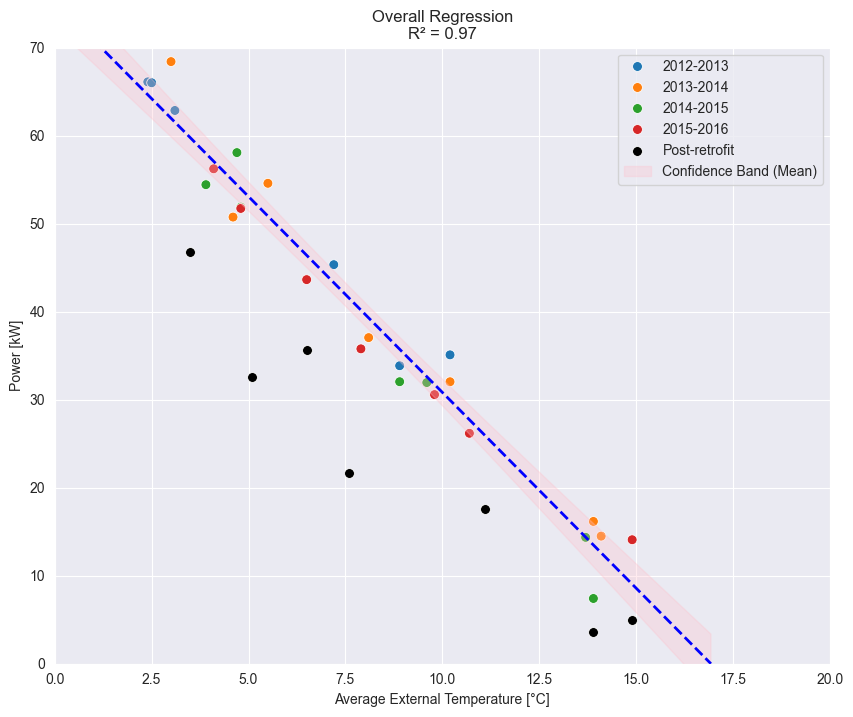

In [28]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='T_media', y='potenza', hue='Stagione', data=df_tot, s=50)
sns.scatterplot(x='T_media', y='potenza', color='black', data=df_post_clean, s=50, label="Post-retrofit")

y_plot = lm_tot.predict(X_plot)
plt.plot(X_plot, y_plot, color='blue', linestyle='--', linewidth=2)

plt.fill_between(X_plot.flatten(), conf_band_lower, conf_band_upper, color='pink', alpha=0.3, label="Confidence Band (Mean)")
    
plt.xlim(0, 20)
plt.ylim(0, 70)

plt.xlabel('Average External Temperature [°C]')
plt.ylabel('Power [kW]')
plt.title(f"Overall Regression\nR² = {r2_tot:.2f}")

plt.legend()
plt.show()

# Plot confidence bands for the regression line


In [29]:
X_post = df_post_clean[['T_media']].values

conf_interval_upper = []
conf_interval_lower = []

for x in X_post:
    x_term = (x - mean_x)**2 / np.sum((X_tot - mean_x)**2)
    margin_of_error = t_value * se * np.sqrt(1 + 1/n + x_term)
    conf_interval_upper.append(lm_tot.predict([x]) + margin_of_error)
    conf_interval_lower.append(lm_tot.predict([x]) - margin_of_error)
    
df_post_clean['pred_upper'] = np.array(conf_interval_upper).flatten()
df_post_clean['pred_lower'] = np.array(conf_interval_lower).flatten()

In [30]:
# Calculate savings from estimated value, lower bound, and upper bound
df_post_clean['consumo_stimato_smc_upper'] = df_post_clean['pred_upper'] * df_post_clean['ore_ON'] / cf
df_post_clean['consumo_stimato_smc_lower'] = df_post_clean['pred_lower'] * df_post_clean['ore_ON'] / cf

energy_saving_upper = df_post_clean['consumo_stimato_smc_upper'].sum() - df_post_clean['consumo_gasm_smc'].sum()
energy_saving_lower = df_post_clean['consumo_stimato_smc_lower'].sum() - df_post_clean['consumo_gasm_smc'].sum()

print(f"Energy saving (Upper Bound): {energy_saving_upper:.2f} smc")
print(f"Energy saving: {energy_saving:.2f} smc")
print(f"Energy saving (Lower Bound): {energy_saving_lower:.2f} smc")


Energy saving (Upper Bound): 7719.25 smc
Energy saving: 4959.75 smc
Energy saving (Lower Bound): 2200.26 smc
